<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Dataset" data-toc-modified-id="Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataset</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Import-datasets" data-toc-modified-id="Import-datasets-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Import datasets</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Helper-functions" data-toc-modified-id="Helper-functions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Helper functions</a></span></li><li><span><a href="#Main-driver-function" data-toc-modified-id="Main-driver-function-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Main driver function</a></span></li><li><span><a href="#Examples" data-toc-modified-id="Examples-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Examples</a></span><ul class="toc-item"><li><span><a href="#EXXON-MOBIL-CORPORATION" data-toc-modified-id="EXXON-MOBIL-CORPORATION-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>EXXON MOBIL CORPORATION</a></span></li><li><span><a href="#NVIDIA-CORPORATION" data-toc-modified-id="NVIDIA-CORPORATION-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>NVIDIA CORPORATION</a></span></li><li><span><a href="#TWITTER-INC" data-toc-modified-id="TWITTER-INC-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>TWITTER INC</a></span></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>References</a></span></li><li><span><a href="#Requirements" data-toc-modified-id="Requirements-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Requirements</a></span></li></ul></div>

# Introduction
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-block alert-warning">
<font color=black>

**What?** Topics analysis of company earning calls.

</font>
</div>

# Dataset
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-block alert-info">
<font color=black>

- The file `transcripts.csv` contains earnings call transcripts for companies within many industries. The csv contains metadata of the call and transcript contents in json format, the data is between a few years. 
- We'd like to show all the key topics mentioned within the company earnings calls.
- What constitutes a topic in NLP is not really clear. Is it a word or a combination of words?
- Because there are quite a lot of data to plot, I have decided to let the user control both the time window and the number of topics as well. The reasons for this will be explained later on in this assignment.

</font>
</div>

# Imports
<hr style = "border:2px solid black" ></hr>

In [1]:
import numpy as np
import gensim
import nltk
import pandas as pd
from gensim import corpora
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models

Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used


In [2]:
# This is a file I had in my script collections
from stop_word_list import *

In [3]:
# Loading the english language small model of spacy
import spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

In [4]:
# Getting rid of the warning messages
import warnings
warnings.filterwarnings("ignore")

# Pandas future warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas

# Import datasets
<hr style = "border:2px solid black" ></hr>

In [5]:
transcripts_df = pd.read_csv("transcripts.csv")

In [6]:
transcripts_df.head(5)

,company,sector,date,raw_transcript
0,EXXON MOBIL CORPORATION,Integrated Oil & Gas,2018-05-10,"{'@id': '2089804', '@product': 'CorrectedTrans..."
1,EXXON MOBIL CORPORATION,Integrated Oil & Gas,2013-10-31,"{'@id': '1591311', '@product': 'CorrectedTrans..."
2,EXXON MOBIL CORPORATION,Integrated Oil & Gas,2018-04-27,"{'@id': '2069690', '@product': 'CorrectedTrans..."
3,NVIDIA CORPORATION,Semiconductors,2011-08-11,"{'@id': '1411983', '@product': 'CorrectedTrans..."
4,INTEL CORPORATION,Semiconductors,2015-08-27,"{'@id': '1770930', '@product': 'CorrectedTrans..."


# EDA
<hr style = "border:2px solid black" ></hr>

In [7]:
# How many companies are there?
transcripts_df["company"].unique()

array(['EXXON MOBIL CORPORATION', 'NVIDIA CORPORATION',
       'INTEL CORPORATION', 'ORSTED A/S', 'BP P.L.C.', 'AES CORP',
       'WPP PLC', 'POSTE ITALIANE', 'NIELSEN HOLDINGS PLC',
       'KNORR BREMSE AG', 'STATE STREET CORP', 'NORTHERN TRUST CORP',
       'TRADE DESK INC CLASS A', 'ABN AMRO BANK NV', 'VERBUND AG',
       'LEIDOS HOLDINGS INC', 'MAGNA INTERNATIONAL INC', 'WELLS FARGO',
       'UNITED UTILITIES GROUP PLC', 'GENUINE PARTS', 'VISTRA CORP',
       'SYNCHRONY FINANCIAL', 'WEC ENERGY GROUP INC',
       'SAREPTA THERAPEUTICS INC', 'TWITTER INC', 'MICHELIN',
       'SOUTHWEST AIRLINES', 'PROLOGIS REIT INC',
       'CATHAY FINANCIAL HOLDING LTD', 'XCEL ENERGY INC', 'THALES SA',
       'EQUITY RESIDENTIAL REIT', 'NATIXIS SA', 'TRANSDIGM GROUP INC',
       'MOTHERSON SUMI SYSTEMS LTD', 'ZIONS BANCORPORATION',
       'UBS GROUP AG', 'PACCAR INC', 'LKQ CORP', 'OMNICOM GROUP INC',
       'ZTO EXPRESS CAYMAN ADR REPRESENTIN', 'YAPI VE KREDI BANKASI A',
       'WESTPAC BANKING CORP

In [8]:
# How many records are associated with EXXON?
transcripts_df[transcripts_df["company"] == "EXXON MOBIL CORPORATION"]

,company,sector,date,raw_transcript
0,EXXON MOBIL CORPORATION,Integrated Oil & Gas,2018-05-10,"{'@id': '2089804', '@product': 'CorrectedTrans..."
1,EXXON MOBIL CORPORATION,Integrated Oil & Gas,2013-10-31,"{'@id': '1591311', '@product': 'CorrectedTrans..."
2,EXXON MOBIL CORPORATION,Integrated Oil & Gas,2018-04-27,"{'@id': '2069690', '@product': 'CorrectedTrans..."
7,EXXON MOBIL CORPORATION,Integrated Oil & Gas,2011-07-05,"{'@id': '1406059', '@product': 'CorrectedTrans..."
9,EXXON MOBIL CORPORATION,Integrated Oil & Gas,2015-10-30,"{'@id': '1778886', '@product': 'CorrectedTrans..."
...,...,...,...,...
785,EXXON MOBIL CORPORATION,Integrated Oil & Gas,2010-10-28,"{'@id': '1342082', '@product': 'CorrectedTrans..."
786,EXXON MOBIL CORPORATION,Integrated Oil & Gas,2011-12-08,"{'@id': '1441729', '@product': 'CorrectedTrans..."
790,EXXON MOBIL CORPORATION,Integrated Oil & Gas,2012-07-26,"{'@id': '1488052', '@product': 'CorrectedTrans..."
794,EXXON MOBIL CORPORATION,Integrated Oil & Gas,2010-11-11,"{'@id': '1351461', '@product': 'CorrectedTrans..."


In [9]:
# How many sectors are associated with each company? Are there any companies that have more than one sector?
for company_temp in transcripts_df["company"].unique():
    if len(transcripts_df[transcripts_df["company"] == company_temp]["sector"].unique()) != 1:
        print(company_temp)

In [10]:
# Double checking this is still true for EXXON
transcripts_df[transcripts_df["company"] == "EXXON MOBIL CORPORATION"]["sector"].unique()

array(['Integrated Oil & Gas'], dtype=object)

# Helper functions
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-block alert-info">
<font color=black>
    
- This section contains a series of helper functions. They mainly deal with the following 3 macro topics:
    - Pandas DataFrame manipulation
    - LDA engine
    - Plotting

</font>
</div>

In [11]:
def get_company_info(df, company_name):
    """Get company info given a name."""
    return df[df["company"] == company_name]

In [12]:
def order_by_date(df):
    """Order by date value."""
    return df.sort_values(by="date", ascending=True, ignore_index=True)

In [13]:
def get_time_window_info(df, begin, end):
    """Get data given a start and an end."""
    return df[(df["date"] >= begin) & (df["date"] <= end)], df[(df["date"] >= begin) & (df["date"] <= end)].shape[0]

In [14]:
def get_only_characters(text):
    """Get only characters.

    Select only the parts of the text that are word.
    This is a quick and dirty way to clean the text!
    """
    return " ".join([i for i in text.split() if i.isalpha()])

In [15]:
def get_bigram(text, frequency):
    """Get birgrams."""

    # Selecting bigram
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = nltk.collocations.BigramCollocationFinder.from_documents([
                                                                      text.split(" ")])
    # Filter only those that occur at least x times
    finder.apply_freq_filter(frequency)
    bigram_scores = finder.score_ngrams(bigram_measures.pmi)

    # Create pandas dataframe
    bigram_pmi = pd.DataFrame(bigram_scores)
    bigram_pmi.columns = ['bigram', 'pmi']
    bigram_pmi.sort_values(by='pmi', axis=0, ascending=False, inplace=True)

    return bigram_pmi

In [16]:
def get_trigram(text, frequency):
    """Get trigrams."""

    # Selecting trigram
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    finder = nltk.collocations.TrigramCollocationFinder.from_documents([
                                                                       text.split(" ")])
    # Filter only those that occur at least x times
    finder.apply_freq_filter(frequency)
    trigram_scores = finder.score_ngrams(trigram_measures.pmi)

    # Create pandas dataframe
    trigram_pmi = pd.DataFrame(trigram_scores)
    trigram_pmi.columns = ['trigram', 'pmi']
    trigram_pmi.sort_values(by='pmi', axis=0, ascending=False, inplace=True)

    return trigram_pmi

In [17]:
def bigram_filter(bigram):
    """Filter bigrams by selecting only nouns."""

    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in sw_spacy or bigram[1] in sw_spacy:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False

    return True

In [18]:
def trigram_filter(trigram):
    """Filter trigrams by selecting only nouns."""

    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ', 'NN']:
        return False
    if trigram[0] in sw_spacy or trigram[-1] in sw_spacy or trigram[1] in sw_spacy:
        return False
    if 'n' in trigram or 't' in trigram:
        return False
    if 'PRON' in trigram:
        return False

    return True

In [19]:
def get_filtered_bigram(bigram_pmi, pmi_threshold):
    """Get only bigrams that have a PMI higher than provided threshold."""

    filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:
                                                  bigram_filter(
                                                      bigram['bigram'])
                                                  and bigram.pmi > 5, axis=1)]

    return filtered_bigram

In [20]:
def get_filtered_trigram(trigram_pmi, pmi_threshold):
    """Get only trigrams that have a PMI higher than provided threshold."""
    
    filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram:
                                                     trigram_filter(
                                                         trigram['trigram'])
                                                     and trigram.pmi > 5, axis=1)]
    
    return filtered_trigram

In [21]:
def get_n_gram_minimum_length(n_gram, n, minimum_length):
    """Get n-gram above a minimum lenght."""

    if n == 2:
        return [' '.join(x) for x in n_gram.bigram.values if len(
            x[0]) > minimum_length or len(x[1]) > minimum_length]
    else:
        return [' '.join(x) for x in n_gram.trigram.values if len(
            x[0]) > minimum_length or len(x[1]) > minimum_length]

In [22]:
def replace_ngram(text, n_gram):
    """Replace ngrams in the text."""

    for gram in n_gram:
        text = text.replace(gram, '_'.join(gram.split()))

    return text

In [23]:
def remove_stop_words(text):
    """Remove stop words."""
    
    new = []
    for word in text.split():
        if word.lower() not in sw_spacy:
            new.append(word)
    
    return " ".join([i for i in new])

In [24]:
def remove_names(text):
    """Remove names."""

    new = []
    for word in text.split():
        if word.lower() not in english_names:
            new.append(word)

    return " ".join([i for i in new])

In [25]:
def noun_only(x):    
    """Filter for only nouns."""
    
    pos_comment = nltk.pos_tag(x.split())

    filtered = []
    for word in pos_comment:
        if word[1][0] == 'N':
            filtered.append(word[0])

    return filtered

In [26]:
def LDA(new, max_topic):
    """Apply LDA to text"""
    
    # Turn text into a pandas series
    new = pd.Series([new])

    # Create a dictionary using gensim corpora
    dictionary = corpora.Dictionary(new)
    
    # Get the vector represenation for each word
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in new]

    # Apply LDA to text
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=max_topic, id2word=dictionary, passes=40,
                   iterations=200,  chunksize=10000, eval_every=None, random_state=0)

    # Get the topic
    topic_data = pyLDAvis.gensim_models.prepare(
        ldamodel, doc_term_matrix, dictionary, mds='pcoa')

    # Create an empty dictionary
    all_topics = {}
    
    # Adjust number of words to represent each topic; could be an hyperparamter
    num_terms = 10
    
    # A value of lambda=0.5 is nothing more than a balanced choice
    lambd = 0.5

    # Append to dictionary
    for i in range(1, max_topic+1):
        topic = topic_data.topic_info[topic_data.topic_info.Category ==
                                      'Topic'+str(i)].copy()

        topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
        all_topics['Topic '+str(i)] = topic.sort_values(by='relevance',
                                                        ascending=False).Term[:num_terms].values

    return all_topics

In [27]:
def plot_top_topic_vs_words(collect, no_topics, no_report, company_name):
    """Plot top topic vs. words.
    
    Paramaters
    ----------
    collect : list of list
        Each list contains a dictionary where each topic has
        a certain number of words (bi-gram or tri-gram as well)
    no_topics : int
        No of topics you want to select
    no_report : int
        No of report/transcript the user wants to consider
    company_name : string
        Name of the company
    
    Returns
    -------
    None
    """
    
    # Autosize the figure base on the chosen no of report
    size_column_fig = int(5*no_report)
    
    fig, axes = plt.subplots(no_report, no_topics, figsize=(
        30, size_column_fig), sharex=True)

    plt.suptitle(company_name, fontsize=50, y=1.01)

    axes = axes.flatten()

    counter = -1
    for temp in collect:

        result = pd.DataFrame(temp).T

        for i, row in result.iterrows():
            counter += 1
            
            # The highest "ranked topic is given value 1 and the least is given 0.1"
            weights = [(i+1)/len(row.values)
                       for i in range(len(row.values))][::-1]
            top_features = row.values
            topic_idx = counter

            ax = axes[topic_idx]
            ax.barh(top_features, weights, height=0.7)

            if counter < no_topics:
                ax.set_title(i,
                             fontdict={'fontsize': 30})

            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=20)

    plt.tight_layout()
    plt.show()

# Main driver function
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-block alert-info">
<font color=black>
    
- The topic selection engine is based on LDA **Latent Dirichlet Allocation**. This method assumes that each document consists of a combination of topics, and each topic consists of a combination of words. It approximates the topic probability distributions in a given document and of words in a given topic. For example:
   - Document 1: Topic1 = 0.4, Topic2 = 0.3, Topic3 = 0.3
   - Topic 1: Product = 0.39, Payment = 0.32, Store = 0.29
   - Document 2: ....
- LDA is a type of Bayesian Inference Model. It assumes that the topics are given as a datum, and infer topics that could have generated the corpus of documents (a review = a document). 
- The number of topics is assumed to be known beforehand. This is the biggest issue of the method and other methods I am aware of do not provide a better alternative. Given the time frame I had available, this method provides at least a good baseline.

- The most important parts of my analysis are:
    - The transcript contains a lot of noisy information that was cleaned in a quick and dirty manner by checking for character only. I am aware that this could potentially throw away important information.
    - LDA used as it is generally done would only returns a list of single words. However, topic can be better described by more words put together. Therefore, my analysis tried to find and feed back into the text some bi- and tri-grams.
    - Because the number of topics needs to be provided by the user, and because we are trying to compare different transcripts an hyper-parameter tuning would have been required for each transcript. Therefore, the risk to obtain different optimal topic number would have prevented us to use a consistent template. Thus, and I admit this may not be ideal, I have built my analysis in a way where the number of topics must be provided by the user, and this is applied to each transcript.
    - The number of financial reports being analysed are automatically selected by providing a time window.
 
</font>
</div>

In [28]:
def analyse_company_topic(df, begin, end, company_name, no_topics):
    """Analyse company topic.
    
    Parameters
    ----------
    df : pandas DataFrame
        
    begin : string in YYYY-MM-DD format
        Time at which the sampling starts
    end : string in YYYY-MM-DD  format
        Time at which the sampling ends
    company_name : string
        Name of the company we are interested in
    no_topics : int
        No of topics 
    
    Returns
    -------
    collect : list of dictionaries
        Each dictionary contains the topic name and its associated
        words
    """
    
    # Get all info given a company name
    df_ = get_company_info(df, company_name)

    # Order by date: old first and newer later
    df_ = order_by_date(df_)

    # Get data given a time window
    df_, no_transcripts = get_time_window_info(df_, begin, end)
    
    # Initialise string to collect all topics
    collect = []
    
    # Loop through the rows
    for i, row in df_.iterrows():
        
        # Get the transcript
        text = row["raw_transcript"]

        # Select only the text that are words
        text_ = get_only_characters(text)
    
        # Get bigrams that have frequency chosen by the user
        bigram_pmi = get_bigram(text_, 2)
        
        # Get trigrams that have frequency chosen by the user
        trigram_pmi = get_trigram(text_, 2)
        
        # Filter bigrams given a pmi threshold chosen by the user
        filtered_bigram = get_filtered_bigram(bigram_pmi, 5)

        # Filter trigrams given a pmi threshold chosen by the user
        filtered_trigram = get_filtered_trigram(trigram_pmi, 5)
        
        # Filter bigrams
        bigrams = get_n_gram_minimum_length(filtered_bigram, 2, 2)
        
        # Filter trigrams
        trigrams = get_n_gram_minimum_length(filtered_trigram, 3, 2)

        # Substitute back bigrams in the text
        text_ = replace_ngram(text_, bigrams)
        
        # Substitute back trigams in the text
        text_ = replace_ngram(text_, trigrams)
    
        # Remove stop words
        text_ = remove_stop_words(text_)

        # Remove English names
        text_ = remove_names(text_)
        
        # Select only name
        text_ = noun_only(text_)
        
        # Get all topics plus associated words
        all_topics = LDA(text_, no_topics)
        
        # Append value
        collect.append(all_topics)
        
    return collect, no_transcripts

# Examples
<hr style = "border:2px solid black" ></hr>

## EXXON MOBIL CORPORATION

In [29]:
# Get min/max available dates
print(min(transcripts_df[transcripts_df["company"] == "EXXON MOBIL CORPORATION"]["date"]))
print(max(transcripts_df[transcripts_df["company"] == "EXXON MOBIL CORPORATION"]["date"]))

2010-01-29
2021-03-03


In [30]:
no_topics = 3
collect, no_transcripts = analyse_company_topic(
    transcripts_df, "2010-01-29", "2010-08-11", "EXXON MOBIL CORPORATION", no_topics)
print("No topics: ", no_topics, " | No of transcripts: ", no_transcripts)

/opt/anaconda3/envs/trainingAI/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/trainingAI/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/trainingAI/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/trainingAI/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/trainingAI/lib/python3.9/site-packages/p

No topics:  3  | No of transcripts:  6


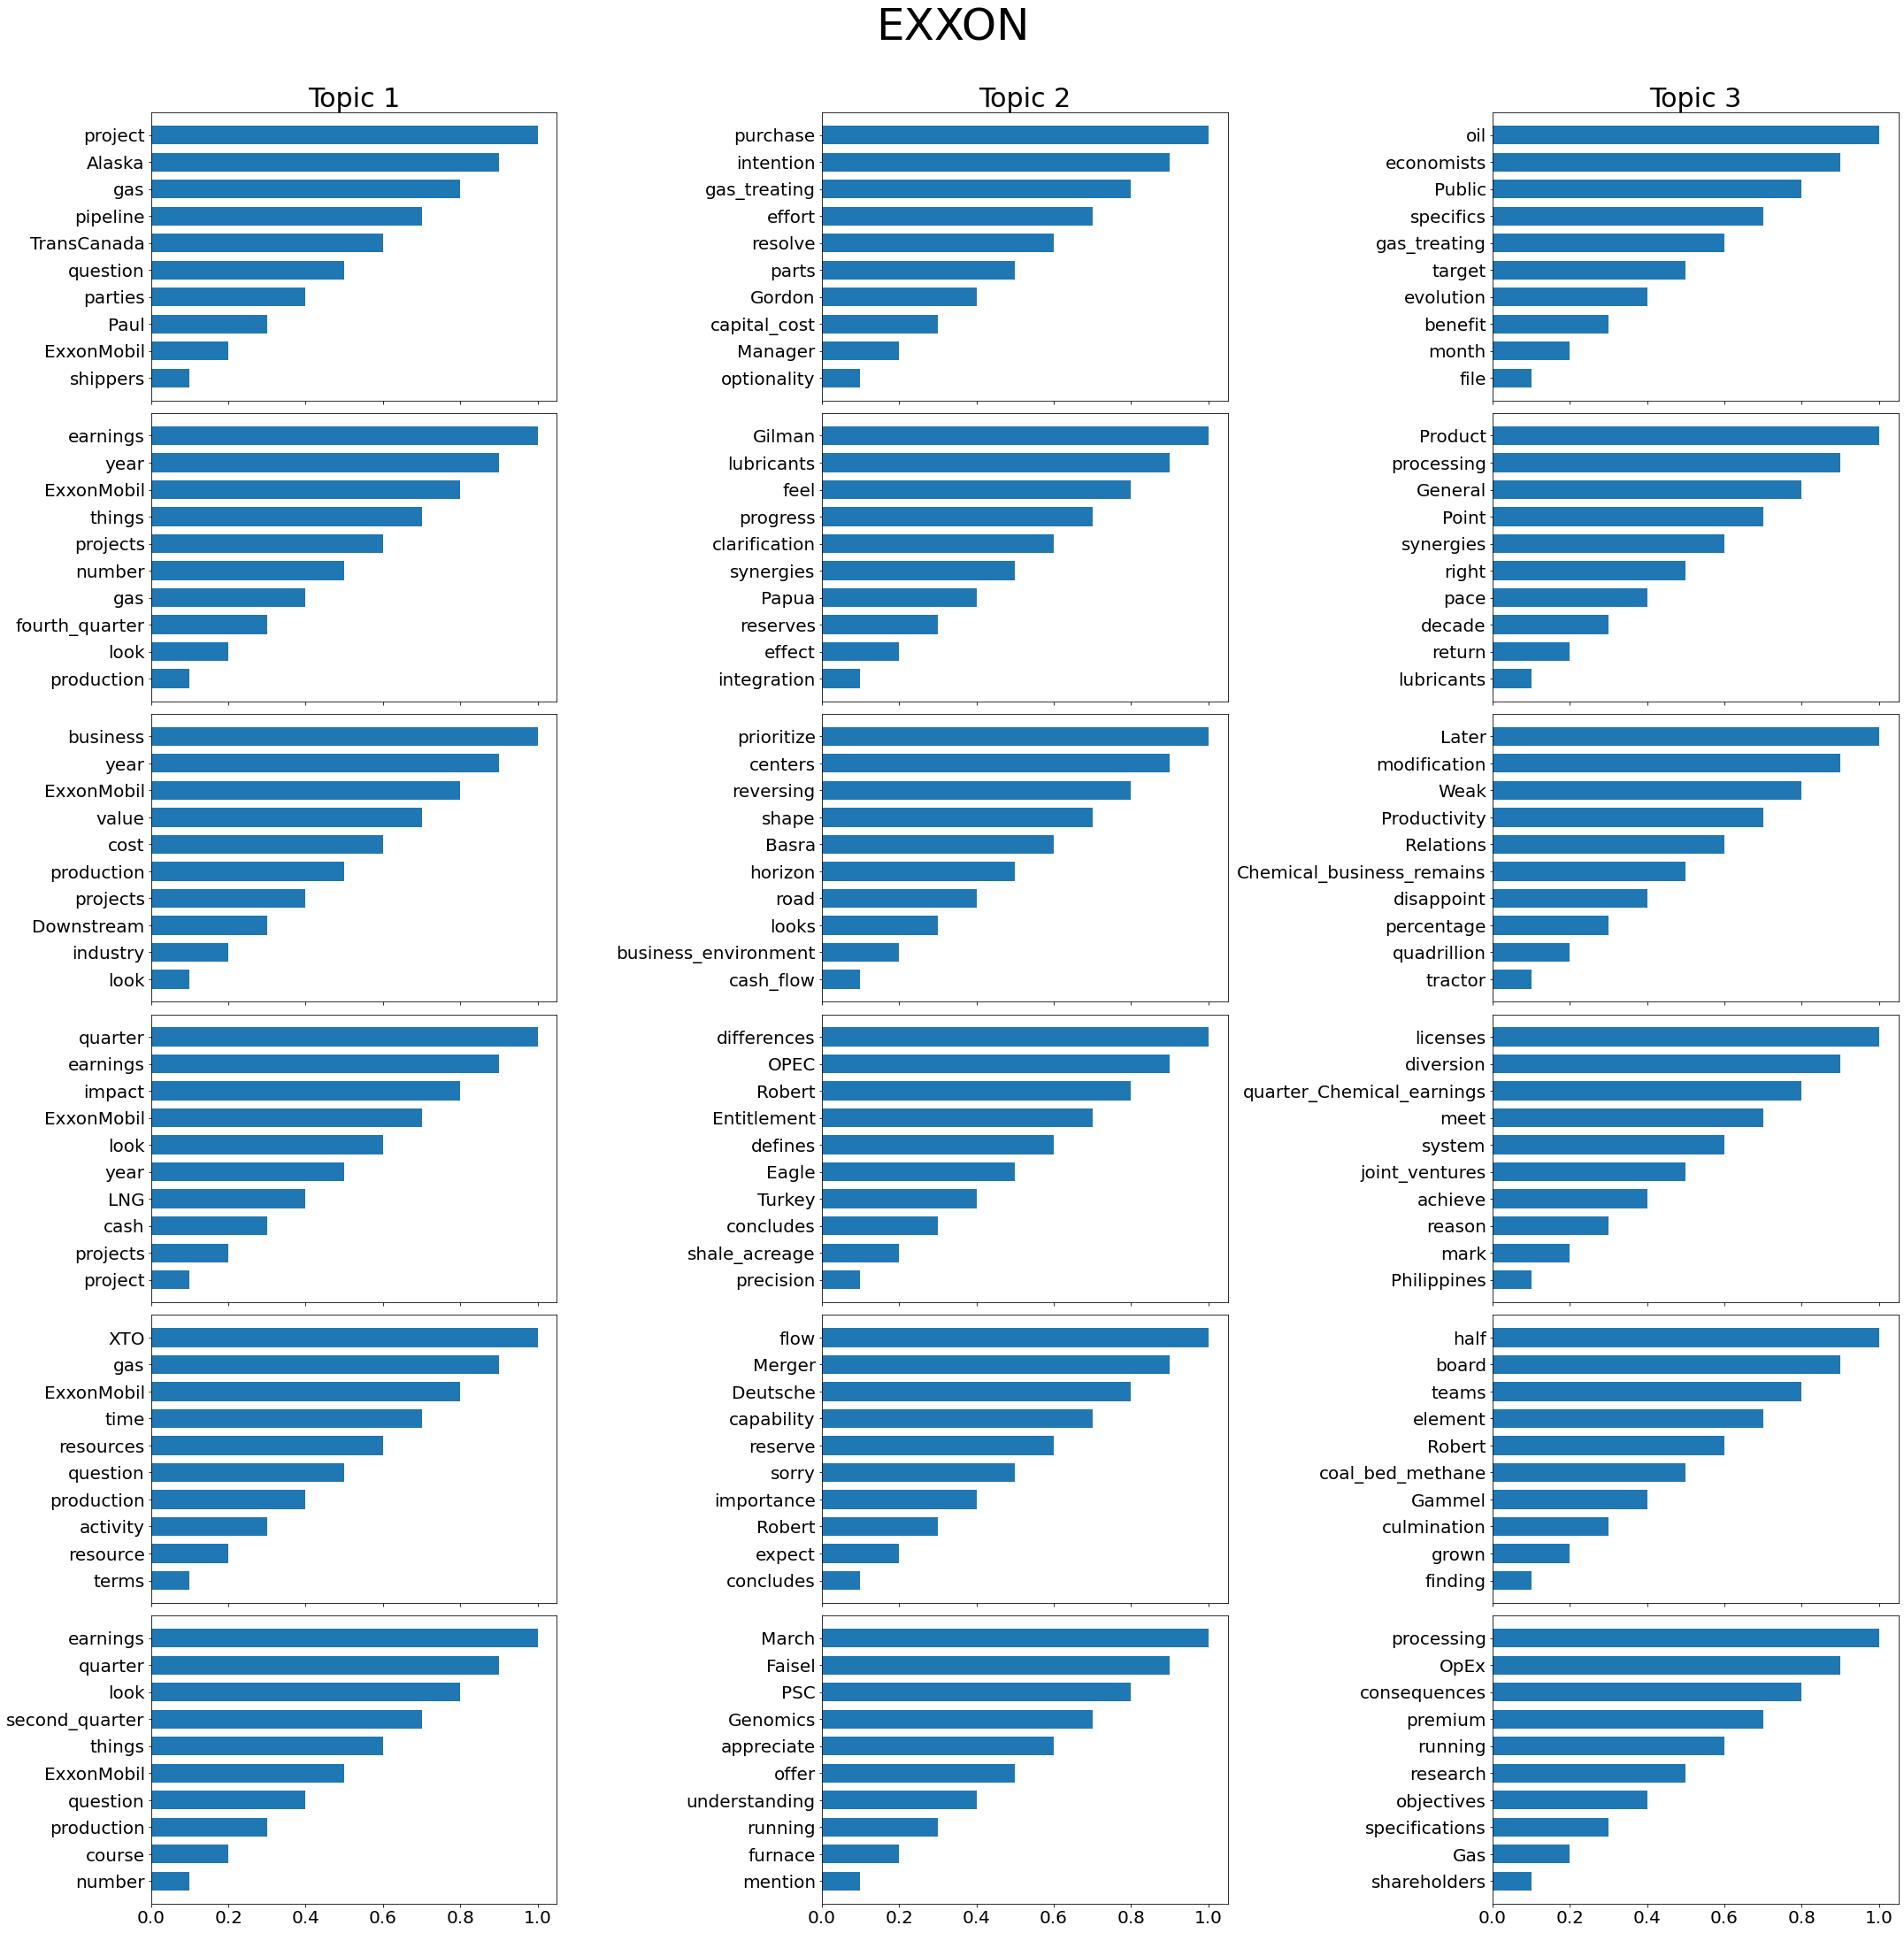

In [31]:
plot_top_topic_vs_words(collect, no_topics, no_transcripts, "EXXON")

## NVIDIA CORPORATION

In [32]:
# Get min/max available dates
print(min(transcripts_df[transcripts_df["company"] == "NVIDIA CORPORATION"]["date"]))
print(max(transcripts_df[transcripts_df["company"] == "NVIDIA CORPORATION"]["date"]))

2010-02-17
2021-01-12


In [33]:
no_topics = 4
collect, no_transcripts = analyse_company_topic(
    transcripts_df, "2010-01-29", "2010-08-11", "NVIDIA CORPORATION", no_topics)
print("No topics: ", no_topics, " | No of transcripts: ", no_transcripts)

No topics:  4  | No of transcripts:  6


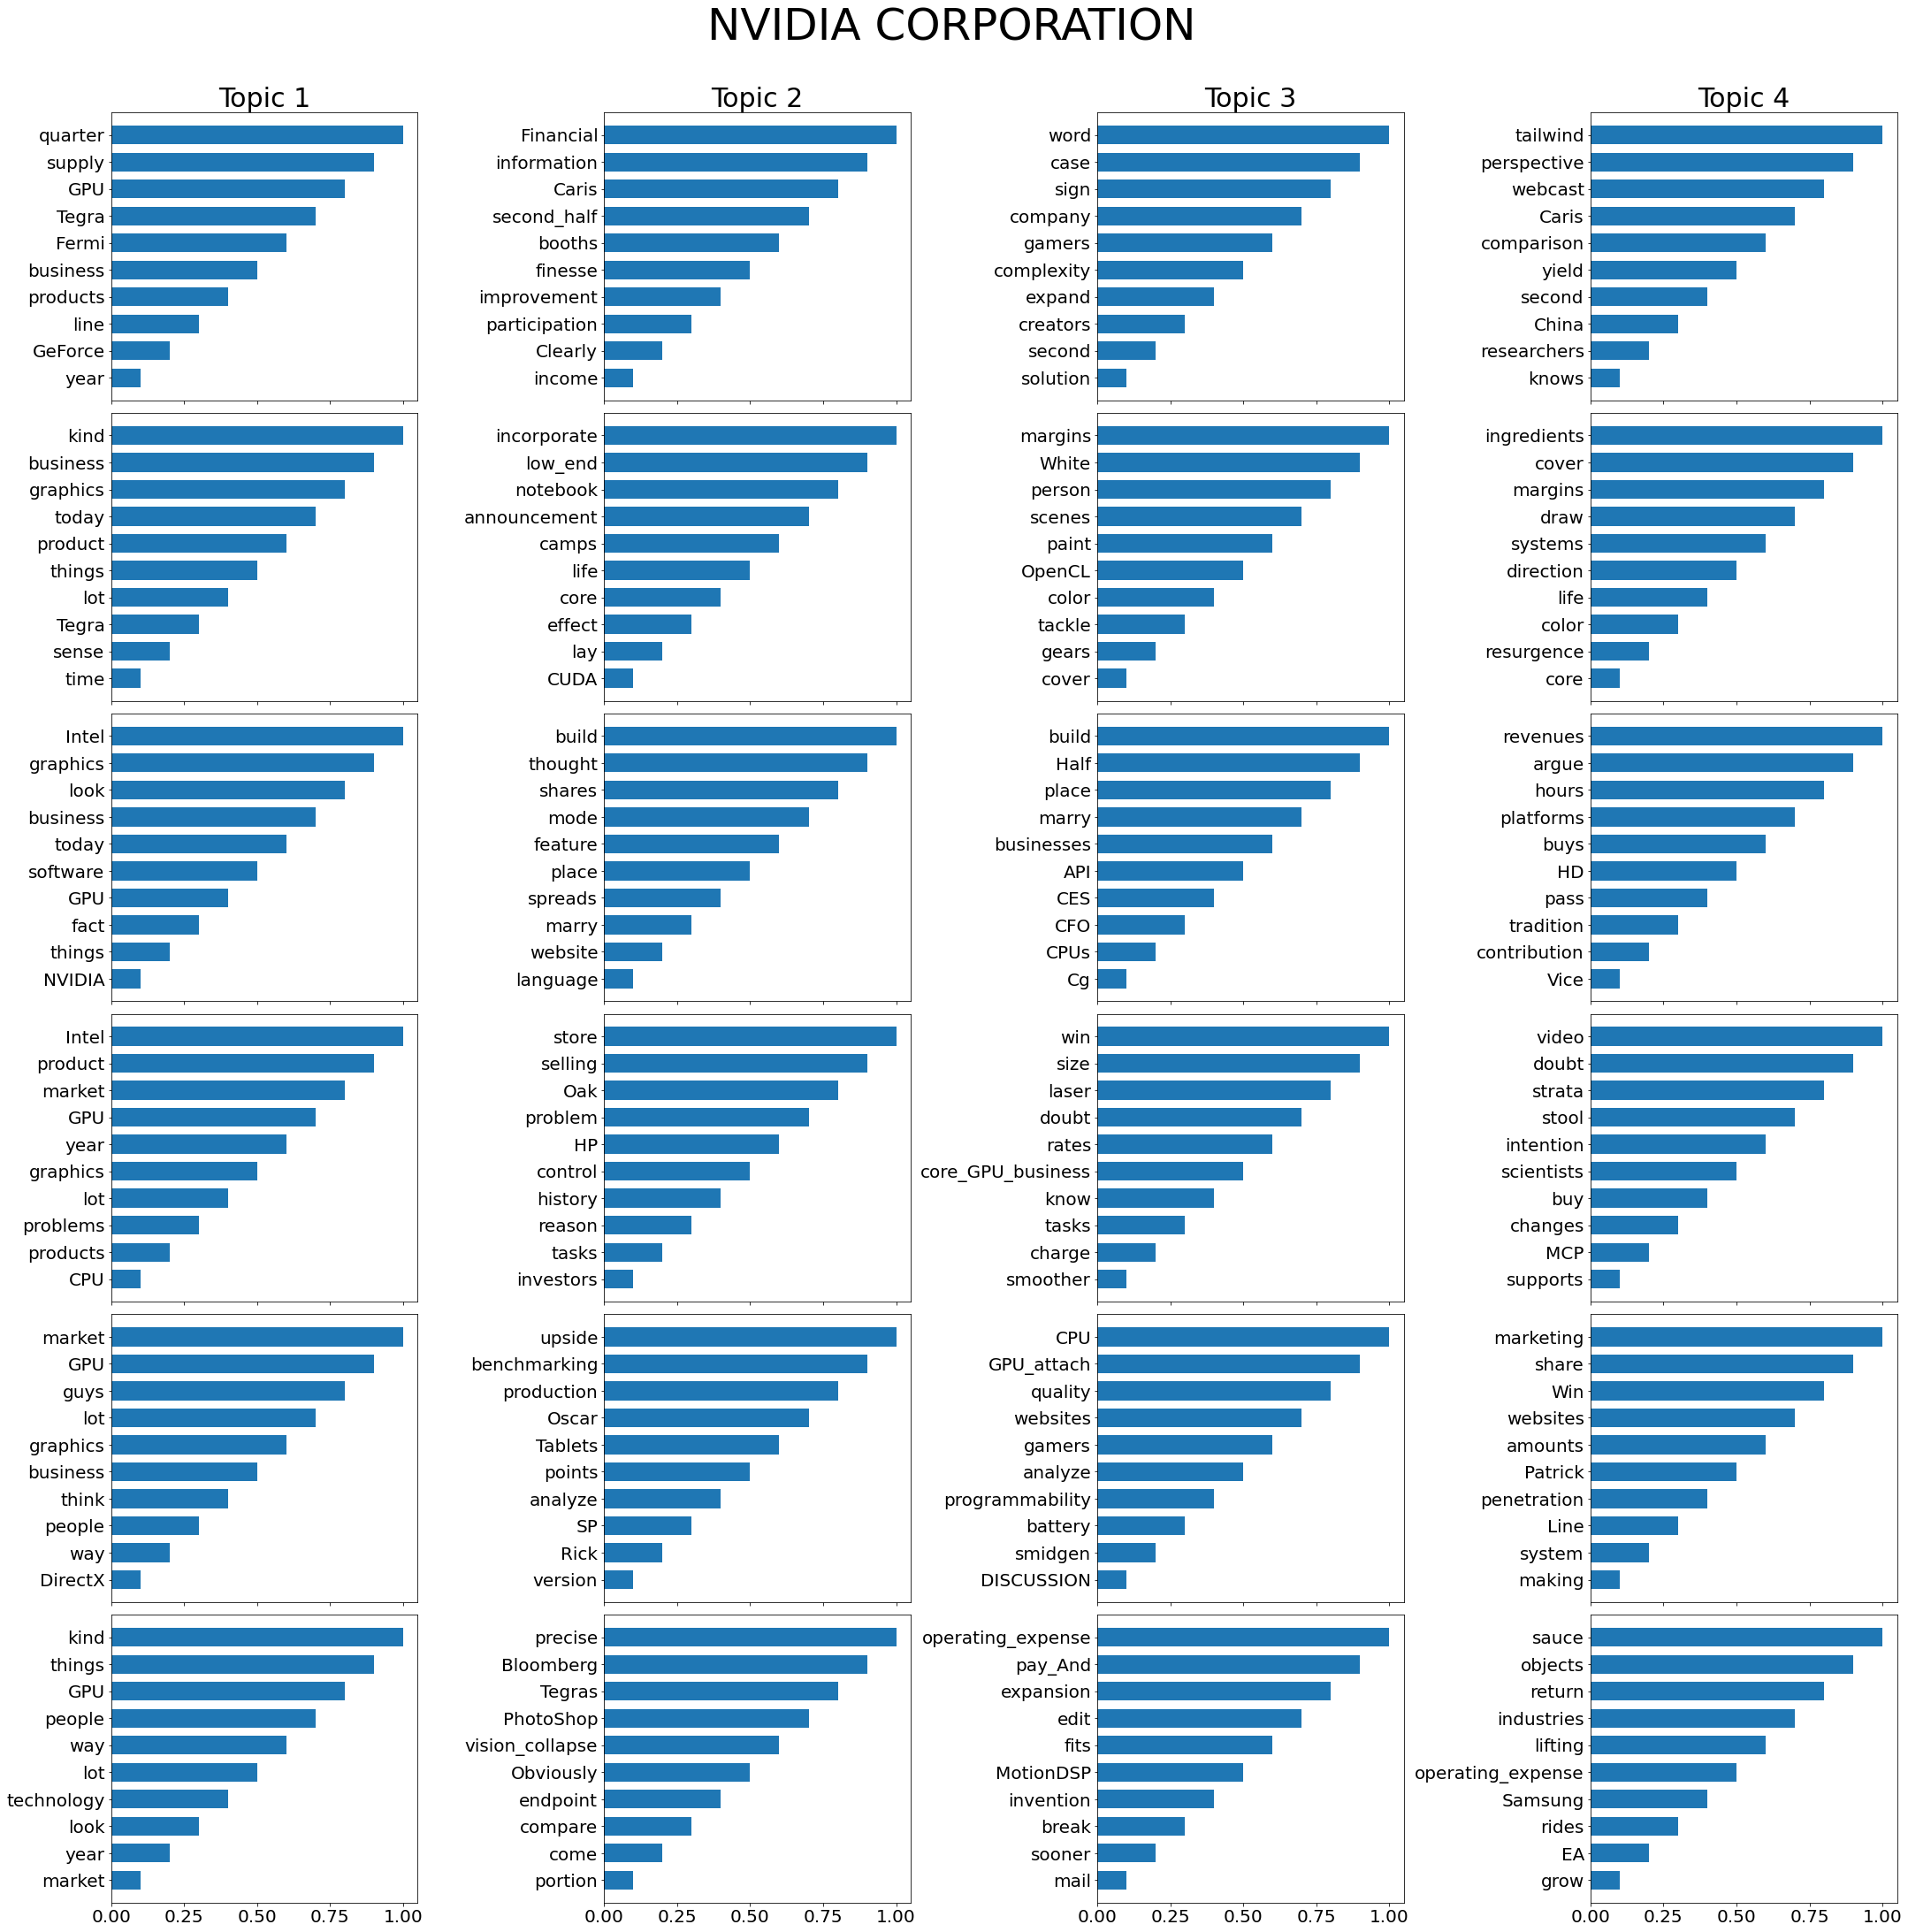

In [34]:
plot_top_topic_vs_words(collect, no_topics, no_transcripts, "NVIDIA CORPORATION")

## TWITTER INC

In [35]:
# Get min/max available dates
print(min(transcripts_df[transcripts_df["company"] == "TWITTER INC"]["date"]))
print(max(transcripts_df[transcripts_df["company"] == "TWITTER INC"]["date"]))

2019-02-07
2021-05-27


In [36]:
no_topics = 2
collect, no_transcripts = analyse_company_topic(
    transcripts_df, "2019-01-29", "2020-08-11", "TWITTER INC", no_topics)
print("No topics: ", no_topics, " | No of transcripts: ", no_transcripts)

No topics:  2  | No of transcripts:  19


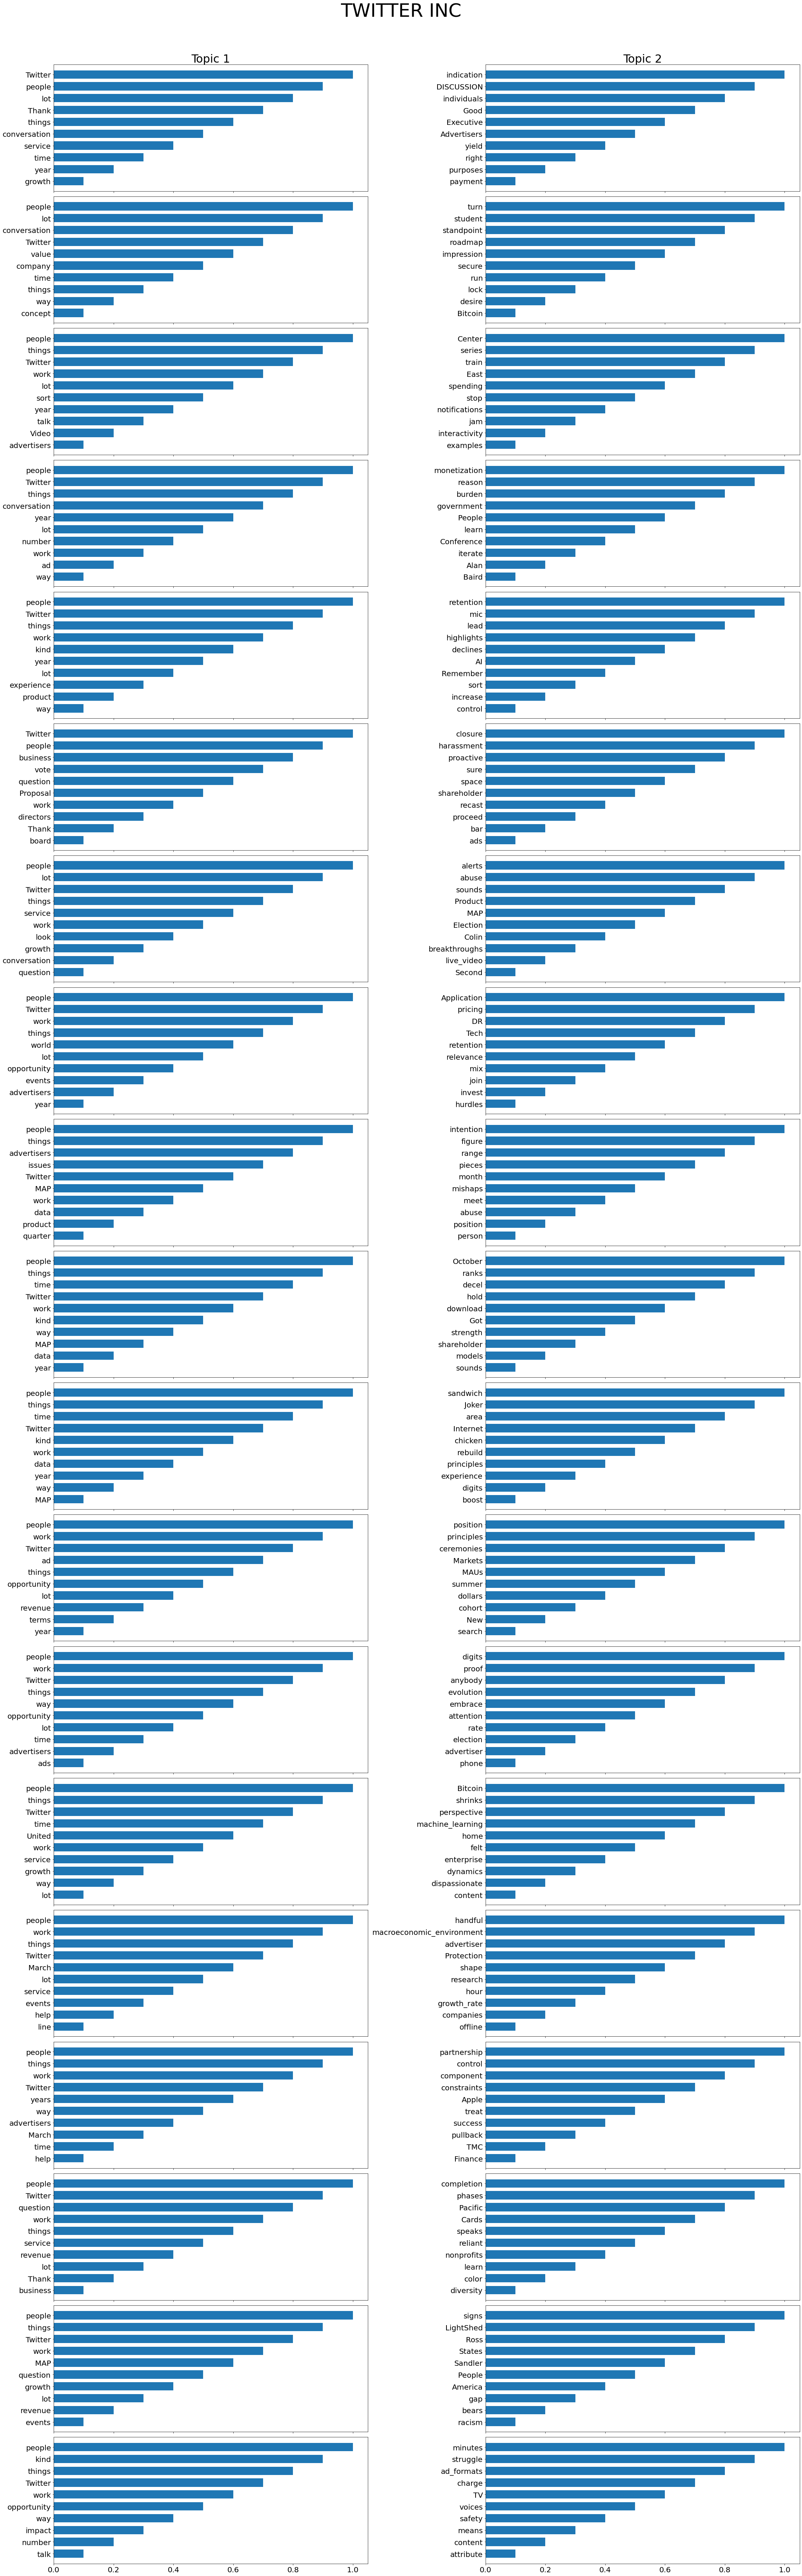

In [37]:
plot_top_topic_vs_words(collect, no_topics, no_transcripts, "TWITTER INC")

# References
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-block alert-warning">
<font color=black>
    
- https://www.nltk.org/howto/collocations.html
- https://pyldavis.readthedocs.io/en/latest/readme.html
    
</font>
</div>

# Requirements
<hr style="border:2px solid black"> </hr>

In [38]:
%load_ext watermark
%watermark -v -iv -m

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 22.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

nltk      : 3.6.7
json      : 2.0.9
spacy     : 3.4.1
pyLDAvis  : 3.3.1
gensim    : 3.2.0
pandas    : 1.5.3
autopep8  : 1.6.0
matplotlib: 3.5.1
numpy     : 1.21.6

